<a href="https://colab.research.google.com/github/ElisaHeinrich/Capstone/blob/master/Simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import statistics as stat
import itertools
from copy import deepcopy
from scipy.stats  import multivariate_normal
import matplotlib 
# matplotlib.use('TkAgg')
from matplotlib import pyplot as plt

import pandas as pd
from IPython.core.debugger import set_trace
import random
import time
import math
import seaborn as sns; sns.set()
import pylab
from random import randrange
import sys 
import scipy
import plotly.graph_objects as go


import warnings
warnings.filterwarnings("ignore")

In [0]:
class base_model(object):

    def __init__(self, grid_size= (10, 10), distr = "SM", n=2):
        '''
        Inputs:
            - Grid size: size of the grid.
            - Distribution: Int. Showing type of initial distribution of the grid
                            Seg: Segregated
                            SM: Semi-mixed (greater granulity)
                            Mix: Completely mixed
 
            - In case of SM distribution, n is an int value that represents
                the size of the neighborhoods. Default: 2.
                    
            
        '''
        #initiating
        self.grid_size = grid_size
        self.distr = distr
        self.n = n

        #populate 
        self.populate(grid_size, distr, n)
        
        #counting steps
        self.step = 0
        
        #for future work - quantifying the heterogeneity of the grid
        self.mean_similarity_value = 0
        self.mean_similarity_ratios = []
        
        #################################
        
        #make empty lists to keep up with data of each model at each step
        self.states = []
        self.rates = []
        
        self.avg_wealth_system=[]
        self.min_wealth = []
        self.max_wealth = []
        self.median = []
        
        
        #################################
        
        #for future reference to make empty lists to keep up with data of each neighborhood at each step
        self.sub_states = []
        self.sub_rates = []
        
        self.sub_avg_wealth_system=[]
        self.sub_min_wealth = []
        self.sub_max_wealth = []
        self.sub_median = []
        
        
        #################################
        #Cate Heine's paper
        self.boost = []
        
    def populate(self, grid_size, distr, n):
        '''
        Populate the grid.
        Input: 
            - Grid Size (grid_size)
            - Distribution (distr)
            - Granularity size (n)
        
        We populate the grid depending on the type of geometry distribution selected.
        (Well mixed city (chessboard-like), Semi-mixed(chessboard-like but with greater granularity (n)), 
        Segregated (completely segregated grid))
        In this case we just have two possible wealth values 5 or 1, this allows us to simplify possible 
        outcomes of the model.
        
        Output:
            Growth rate and Wealth grids with selected attributes.
        
        '''
        #base grids
        self.growth_rate = np.ones(self.grid_size)
        self.wealth = np.ones(self.grid_size)*5

        # Segregated grid case
        if self.distr == "Seg":
            self.wealth[:, :int(self.grid_size[1]/2)]= 1
        
        # Semi-mixed grid case, using n to consider the granularity
        elif self.distr == "SM":
            
            for i in range(self.n, 2*self.n):
                for j in range(self.n):
                    self.wealth[j::2*self.n, i::2*self.n] =1

            for i in range(self.n):
                for j in range(self.n, 2*self.n):
                    self.wealth[j::2*n, i::2*self.n] =1
                    
            
        #well mixed grid
        elif self.distr == "Mix" :
            for i in range(self.grid_size[0]):
                for j in range(self.grid_size[1]):
                    if (i+j)%2:
#                         self.wealth[i][j] = np.random.uniform(100, 500, 1)
                        self.wealth[i][j] = 1
    
    
        #growth-rate grid based on the wealth grid
        C=10**-5
        self.growth_rate = C*self.wealth 
    
    


    def display(self):
        '''
        Plot the state of the model.
        
        '''
        plt.figure()
        plt.imshow(self.wealth)
        plt.colorbar()
        plt.title('Step: ' + str(self.step))

# animation of the evolution of the distribution
#         pylab.clf()
#         pylab.subplot(2, 2, 1)
#         pylab.pcolor(self.wealth)
#         plt.title('Wealth')
#         plt.axis('off')
#         plt.colorbar(label= 'Wealth')
        
#         pylab.subplot(2, 2, 2)
#         pylab.pcolor(self.growth_rate)
#         plt.title('Growth Rate')
#         plt.axis('off')
#         plt.colorbar(label='Growth rate')

        
#         pylab.subplot(2, 2, 3)
#         s= sns.distplot(sim.wealth[~np.isnan(sim.wealth)], rug= True)
#         plt.subplots_adjust( hspace=0.5, wspace=0.5)


# #         s.set_xscale('log')
# #         s.set_yscale('log')

#         pylab.title('Wealth Distribution'+', Step = ' + str(self.step))
#         plt.title('Wealth Distribution')
#         plt.xlabel('Wealth')
#         plt.ylabel('Distribution')
#         plt.show()


    def get_avg_val(self, matrix):
        '''
        Returns the average of state value. (float)
        
        '''
        return np.nanmean(matrix)
    
    
    def get_min_val(self, matrix):
        '''
        Return the minimum wealth value.
        
        '''
        
        return np.nanmin(matrix)
    
        
    def get_max_val(self, matrix):
        '''
        Return the maximum wealth value.
        
        '''
        
        return np.nanmax(matrix)
        
  
    def get_median(self, matrix):
        '''
        Return the median of the current matrix
        
        '''
        
        return np.nanmedian(matrix)
    
    
    def get_std(self, matrix):
        '''
        Return the standard deviation of the current matrix
        '''
        
        return np.nanstd(matrix)
    
    def entropy(self, sub_wealth, grid_size, sim_range=0.2):
        '''
        [Corrently I am not using this function, since I am setting up a determined initial distribution]
        
        Output a value representing the heterogeneity of the grid (or part of a grid) in a certain step.
        
        Input:
            - Wealth Grid (or sub-part of the wealt grid)
            - Grid size
            - Similarity range (how much percentage of similarity should have in order to consider 
                                the cells from the same class)
        
        '''

        similarity_ratios = []    
        
        #in this case, I was considering just one subpart of the whole grid, upper-left corner
        for x in range(int((self.grid_size[0])/2)):
            for y in range(int((self.grid_size[1])/2)):
                #analyze each cell of the Grid
                similar = 0
                different = 0
                
                #considering a Moore Neighborhood
                combinations = itertools.product([-1, 0, 1], [-1, 0, 1])
                
                #I should change this part in the future, since consider a non-periodic boundary condition
                for i, j in combinations:
                    x_coordinate = (x + i) % len(sub_wealth)
                    y_coordinate = (y + j) % len(sub_wealth[0])

                    #considering the value in sim_range, we consider how different are expected the value of wealth of the 
                    #neighbors to consider similar or different
                    if self.sub_wealth[x][y]* - sim_range + self.sub_wealth[x][y] <= self.sub_wealth[x_coordinate][y_coordinate]<= self.sub_wealth[x][y] + self.sub_wealth[x][y] * sim_range:
                        similar +=1
                    else:
                        different +=1
                #once each cell has a value, then we can consider a whole similarity value for the grid
                if (similar + different) == 0:
                    similarity_ratios.append(0)
                
                else:
                    self.mean_similarity_value += (similar)/(similar+different)
                    similarity_ratios.append((similar)/(similar+different))

        return(self.mean_similarity_ratios.append(np.nanmean(similarity_ratios)))

        
        
    def update_grid(self, corr = True):
        '''
        Updating the Grid at each step. 
        Input: 
            - corr: Boolean. Consider whether or not we are considering the averaging effect of the neighborhood.
        
        We are considering cut-off boundary conditions.
        
        '''
        # we will consider the average wealth of the neighborhood of each cell.
        
        # create an average wealth matrix with the average of the negihborhood of each cell
        avg= np.ones(self.grid_size)
        
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                
                #having cut-off boundary conditions
                if x == 0:
                    a =[0, 1]
                    xn = 2
                    
                elif x == (self.grid_size[0]-1):
                    a = [-1, 0]
                    xn = 2
                    
                elif x !=0 and x !=(self.grid_size[0]-1):
                    a=[-1, 0, 1]
                    xn = 3

                if y == 0:
                    b = [0, 1]
                    yn = 2
                    
                elif y == (self.grid_size[1]-1):
                    b = [-1, 0]
                    yn = 2

                elif y !=0 and y != (self.grid_size[1]-1):
                    b= [-1, 0, 1]
                    yn = 3

                combinations = itertools.product(a, b)
                
                value=0
                for xi, yi in combinations:
                    x_coordinate = (x + xi) % len(self.wealth[0])
                    y_coordinate = (y + yi) % len(self.wealth[1])

                    value += self.wealth[x_coordinate][y_coordinate]
                avg[x][y]=value/(xn*yn)
                
        
        new_state = self.wealth + self.wealth* self.growth_rate
        C= 0.0001
        
        if corr:
            #If considering correlation then we are considering the average matrix
            new_growth= C*np.log(self.wealth + avg)
            
        else: 
            new_growth = C*np.log(self.wealth)
       
        self.wealth = new_state 
        self.growth_rate = new_growth
        
        self.sub_wealth = self.wealth[0:int(self.grid_size[1]/2),0:int(self.grid_size[1]/2)]
        self.sub_growth_rate = self.growth_rate[0:int(self.grid_size[1]/2),0:int(self.grid_size[1]/2)]
        
        
        ################################################################
        #appending values for each step
        
        self.states.append(self.wealth)
        self.rates.append(self.growth_rate)
        
        self.avg_wealth_system.append(self.get_avg_val(self.wealth))
        self.min_wealth.append(self.get_min_val(self.wealth))
        self.max_wealth.append(self.get_max_val(self.wealth))
        self.median.append(self.get_median(self.wealth))
        
        ###############################################################
        #considering sub-structures
        
        self.entropy(self.sub_wealth, self.grid_size)
        
        self.sub_states.append(self.sub_wealth)
        self.sub_rates.append(self.sub_growth_rate)
        
        self.sub_avg_wealth_system.append(self.get_avg_val(self.sub_wealth))
        self.sub_min_wealth.append(self.get_min_val(self.sub_wealth))
        self.sub_max_wealth.append(self.get_max_val(self.sub_wealth))
        self.sub_median.append(self.get_median(self.sub_wealth))
        
        ###############################################################
# when using boost parameter
#         ratio_xX =(int(sim.grid_size[0]/2)*int(sim.grid_size[1]/2))/(int(sim.grid_size[0])*int(sim.grid_size[1]))
#         Y= self.avg_wealth_system[-1]
#         y= self.sub_avg_wealth_system[-1]
#         b= y/(Y*ratio_xX)
#         self.boost.append(b)
        
        self.step += 1
        
## for animation        
# sim = base_model()
# import pycxsimulator
# gui = pycxsimulator.GUI()
# gui.start(func=[sim.initialize, sim.observe, sim.update_grid])

### Distribution - Grid & Neighborhood Size

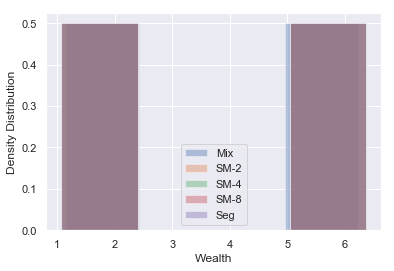

In [0]:
'''

Distribution for Grid size 16x16. In the different initial Conditions:
    - Well Mixed
    - Semi-Mixed with neighborhood sizes as 2, 4, and 8
    - Segregated

'''

peak_ratios_16 = []


sim_1_16 = base_model(grid_size= (16, 16), distr = "Mix")
for _ in range(1000):
    sim_1_16.update_grid()
    
sim_1_16_low_dist = sim_1_16.wealth[sim_1_16.wealth< np.median(sim_1_16.wealth)]
sim_1_16_high_dist = sim_1_16.wealth[sim_1_16.wealth> np.median(sim_1_16.wealth)]

sim_1_16_low_peak = np.mean(sim_1_16_low_dist)
sim_1_16_high_peak = np.mean(sim_1_16_high_dist)

sim_1_16_ = sim_1_16.wealth[~np.isnan(sim_1_16.wealth)]

peak_ratios_16.append(sim_1_16_low_peak/sim_1_16_high_peak)

     
sim_2_16 = base_model(grid_size= (16, 16), distr = "SM", n=2)
for _ in range(1000):
    sim_2_16.update_grid()
    
sim_2_16_low_dist = sim_2_16.wealth[sim_2_16.wealth< np.median(sim_2_16.wealth)]
sim_2_16_high_dist = sim_2_16.wealth[sim_2_16.wealth> np.median(sim_2_16.wealth)]

sim_2_16_low_peak = np.mean(sim_2_16_low_dist)
sim_2_16_high_peak = np.mean(sim_2_16_high_dist)

sim_2_16_ = sim_2_16.wealth[~np.isnan(sim_2_16.wealth)]

peak_ratios_16.append(sim_2_16_low_peak/sim_2_16_high_peak)
    
sim_3_16 = base_model(grid_size= (16, 16), distr = "SM", n=4)
for _ in range(1000):
    sim_3_16.update_grid()
    
sim_3_16_low_dist = sim_3_16.wealth[sim_3_16.wealth< np.median(sim_3_16.wealth)]
sim_3_16_high_dist = sim_3_16.wealth[sim_3_16.wealth> np.median(sim_3_16.wealth)]

sim_3_16_low_peak = np.mean(sim_3_16_low_dist)
sim_3_16_high_peak = np.mean(sim_3_16_high_dist)

peak_ratios_16.append(sim_3_16_low_peak/sim_3_16_high_peak)
    
sim_3_16_ = sim_3_16.wealth[~np.isnan(sim_3_16.wealth)]

sim_4_16 = base_model(grid_size= (16, 16), distr = "SM", n=8)
for _ in range(1000):
    sim_4_16.update_grid()
    
sim_4_16_low_dist = sim_4_16.wealth[sim_4_16.wealth< np.median(sim_4_16.wealth)]
sim_4_16_high_dist = sim_4_16.wealth[sim_4_16.wealth> np.median(sim_4_16.wealth)]

sim_4_16_low_peak = np.mean(sim_4_16_low_dist)
sim_4_16_high_peak = np.mean(sim_4_16_high_dist)

sim_4_16_ = sim_4_16.wealth[~np.isnan(sim_4_16.wealth)]

peak_ratios_16.append(sim_4_16_low_peak/sim_4_16_high_peak)
    
    
sim_5_16 = base_model(grid_size= (16, 16), distr = "Seg")
for _ in range(1000):
    sim_5_16.update_grid()
    
sim_5_16_low_dist = sim_5_16.wealth[sim_5_16.wealth< np.median(sim_5_16.wealth)]
sim_5_16_high_dist = sim_5_16.wealth[sim_5_16.wealth> np.median(sim_5_16.wealth)]

sim_5_16_low_peak = np.mean(sim_5_16_low_dist)
sim_5_16_high_peak = np.mean(sim_5_16_high_dist)

sim_5_16_ = sim_5_16.wealth[~np.isnan(sim_5_16.wealth)]

peak_ratios_16.append(sim_5_16_low_peak/sim_5_16_high_peak)
    
    
s= sns.distplot(sim_1_16_ , hist=True, kde=False, label='Mix',
             hist_kws={'weights': np.full(len(sim_1_16_), 1/len(sim_1_16_))})
s= sns.distplot(sim_2_16_ , hist=True, kde=False, label='SM-2',
             hist_kws={'weights': np.full(len(sim_2_16_), 1/len(sim_2_16_))})
s= sns.distplot(sim_3_16_ , hist=True, kde=False, label='SM-4',
             hist_kws={'weights': np.full(len(sim_3_16_), 1/len(sim_3_16_))})
s= sns.distplot(sim_4_16_ , hist=True, kde=False, label='SM-8',
             hist_kws={'weights': np.full(len(sim_4_16_), 1/len(sim_4_16_))})
s= sns.distplot(sim_5_16_ , hist=True, kde=False, label='Seg',
             hist_kws={'weights': np.full(len(sim_5_16_), 1/len(sim_5_16_))})


plt.xlabel('Wealth')
plt.ylabel('Density Distribution')
plt.legend()
plt.savefig('Desktop\Dens_Distr.png')
plt.show()

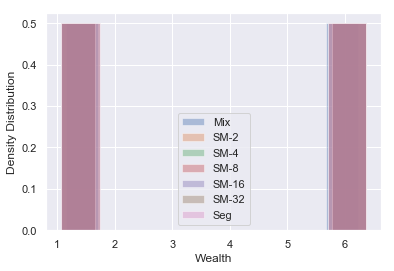

In [0]:
'''

Distribution for Grid size 64x64. In the different initial Conditions:
    - Well Mixed
    - Semi-Mixed with neighborhood sizes as 2, 4, 8, 16, 32, 64, 128, 256 
    - Segregated

'''

peak_ratios_64 = []


sim_1_64 = base_model(grid_size= (64, 64), distr = "Mix")
for _ in range(1000):
    sim_1_64.update_grid()
    
sim_1_64_low_dist = sim_1_64.wealth[sim_1_64.wealth< np.median(sim_1_64.wealth)]
sim_1_64_high_dist = sim_1_64.wealth[sim_1_64.wealth> np.median(sim_1_64.wealth)]

sim_1_64_low_peak = np.mean(sim_1_64_low_dist)
sim_1_64_high_peak = np.mean(sim_1_64_high_dist)

sim_1_64_ = sim_1_64.wealth[~np.isnan(sim_1_64.wealth)]

peak_ratios_64.append(sim_1_64_low_peak/sim_1_64_high_peak)

     
sim_2_64 = base_model(grid_size= (64, 64), distr = "SM", n=2)
for _ in range(1000):
    sim_2_64.update_grid()
    
sim_2_64_low_dist = sim_2_64.wealth[sim_2_64.wealth< np.median(sim_2_64.wealth)]
sim_2_64_high_dist = sim_2_64.wealth[sim_2_64.wealth> np.median(sim_2_64.wealth)]

sim_2_64_low_peak = np.mean(sim_2_64_low_dist)
sim_2_64_high_peak = np.mean(sim_2_64_high_dist)

sim_2_64_ = sim_2_64.wealth[~np.isnan(sim_2_64.wealth)]

peak_ratios_64.append(sim_2_64_low_peak/sim_2_64_high_peak)
    
    
sim_3_64 = base_model(grid_size= (64, 64), distr = "SM", n=4)
for _ in range(1000):
    sim_3_64.update_grid()
    
sim_3_64_low_dist = sim_3_64.wealth[sim_3_64.wealth< np.median(sim_3_64.wealth)]
sim_3_64_high_dist = sim_3_64.wealth[sim_3_64.wealth> np.median(sim_3_64.wealth)]

sim_3_64_low_peak = np.mean(sim_3_64_low_dist)
sim_3_64_high_peak = np.mean(sim_3_64_high_dist)

peak_ratios_64.append(sim_3_64_low_peak/sim_3_64_high_peak)
    
sim_3_64_ = sim_3_64.wealth[~np.isnan(sim_3_64.wealth)]


sim_4_64 = base_model(grid_size= (64, 64), distr = "SM", n=8)
for _ in range(1000):
    sim_4_64.update_grid()
    
sim_4_64_low_dist = sim_4_64.wealth[sim_4_64.wealth< np.median(sim_4_64.wealth)]
sim_4_64_high_dist = sim_4_64.wealth[sim_4_64.wealth> np.median(sim_4_64.wealth)]

sim_4_64_low_peak = np.mean(sim_4_64_low_dist)
sim_4_64_high_peak = np.mean(sim_4_64_high_dist)

sim_4_64_ = sim_4_64.wealth[~np.isnan(sim_4_64.wealth)]

peak_ratios_64.append(sim_4_64_low_peak/sim_4_64_high_peak)


sim_5_64 = base_model(grid_size= (64, 64), distr = "SM", n=16)
for _ in range(1000):
    sim_5_64.update_grid()
    
sim_5_64_low_dist = sim_5_64.wealth[sim_5_64.wealth< np.median(sim_5_64.wealth)]
sim_5_64_high_dist = sim_5_64.wealth[sim_5_64.wealth> np.median(sim_5_64.wealth)]

sim_5_64_low_peak = np.mean(sim_5_64_low_dist)
sim_5_64_high_peak = np.mean(sim_5_64_high_dist)

sim_5_64_ = sim_5_64.wealth[~np.isnan(sim_5_64.wealth)]

peak_ratios_64.append(sim_5_64_low_peak/sim_5_64_high_peak)


sim_6_64 = base_model(grid_size= (64, 64), distr = "SM", n=32)
for _ in range(1000):
    sim_6_64.update_grid()
    
sim_6_64_low_dist = sim_6_64.wealth[sim_6_64.wealth< np.median(sim_6_64.wealth)]
sim_6_64_high_dist = sim_6_64.wealth[sim_6_64.wealth> np.median(sim_6_64.wealth)]

sim_6_64_low_peak = np.mean(sim_6_64_low_dist)
sim_6_64_high_peak = np.mean(sim_6_64_high_dist)

sim_6_64_ = sim_6_64.wealth[~np.isnan(sim_6_64.wealth)]

peak_ratios_64.append(sim_6_64_low_peak/sim_6_64_high_peak)

    
sim_9_64 = base_model(grid_size= (64, 64), distr = "Seg")
for _ in range(1000):
    sim_9_64.update_grid()
    
sim_9_64_low_dist = sim_9_64.wealth[sim_9_64.wealth< np.median(sim_9_64.wealth)]
sim_9_64_high_dist = sim_9_64.wealth[sim_9_64.wealth> np.median(sim_9_64.wealth)]

sim_9_64_low_peak = np.mean(sim_9_64_low_dist)
sim_9_64_high_peak = np.mean(sim_9_64_high_dist)

sim_9_64_ = sim_9_64.wealth[~np.isnan(sim_9_64.wealth)]

peak_ratios_64.append(sim_9_64_low_peak/sim_9_64_high_peak)
    
    
s= sns.distplot(sim_1_64_ , hist=True, kde=False,label='Mix',
             hist_kws={'weights': np.full(len(sim_1_64_), 1/len(sim_1_64_))})
s= sns.distplot(sim_2_64_ , hist=True, kde=False, label='SM-2',
             hist_kws={'weights': np.full(len(sim_2_64_), 1/len(sim_2_64_))})
s= sns.distplot(sim_3_64_ , hist=True, kde=False, label='SM-4',
             hist_kws={'weights': np.full(len(sim_3_64_), 1/len(sim_3_64_))})
s= sns.distplot(sim_4_64_ , hist=True, kde=False, label='SM-8',
             hist_kws={'weights': np.full(len(sim_4_64_), 1/len(sim_4_64_))})
s= sns.distplot(sim_5_64_ , hist=True, kde=False, label='SM-16',
             hist_kws={'weights': np.full(len(sim_5_64_), 1/len(sim_5_64_))})
s= sns.distplot(sim_6_64_ , hist=True, kde=False, label='SM-32',
             hist_kws={'weights': np.full(len(sim_6_64_), 1/len(sim_6_64_))})
s= sns.distplot(sim_9_64_ , hist=True, kde=False, label='Seg',
             hist_kws={'weights': np.full(len(sim_9_64_), 1/len(sim_9_64_))})

plt.xlabel('Wealth')
plt.ylabel('Density Distribution')
plt.legend()
plt.show()

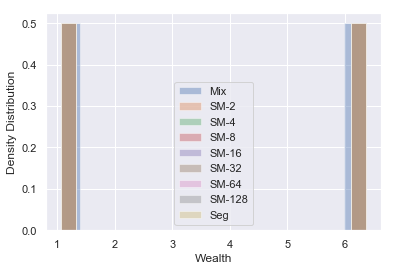

In [0]:
'''

Distribution for Grid size 256x256. In the different initial Conditions:
    - Well Mixed
    - Semi-Mixed with neighborhood sizes as 2, 4, 8, 16, 32, 64, 128, 256 
    - Segregated

'''

peak_ratios_256 = []


sim_1_256 = base_model(distr = "Mix")
for _ in range(1000):
    sim_1_256.update_grid()
    
sim_1_256_low_dist = sim_1_256.wealth[sim_1_256.wealth< np.median(sim_1_256.wealth)]
sim_1_256_high_dist = sim_1_256.wealth[sim_1_256.wealth> np.median(sim_1_256.wealth)]

sim_1_256_low_peak = np.mean(sim_1_256_low_dist)
sim_1_256_high_peak = np.mean(sim_1_256_high_dist)

sim_1_256_ = sim_1_256.wealth[~np.isnan(sim_1_256.wealth)]

peak_ratios_256.append(sim_1_256_low_peak/sim_1_256_high_peak)

     
sim_2_256 = base_model(distr = "SM", n=2)
for _ in range(1000):
    sim_2_256.update_grid()
    
sim_2_256_low_dist = sim_2_256.wealth[sim_2_256.wealth< np.median(sim_2_256.wealth)]
sim_2_256_high_dist = sim_2_256.wealth[sim_2_256.wealth> np.median(sim_2_256.wealth)]

sim_2_256_low_peak = np.mean(sim_2_256_low_dist)
sim_2_256_high_peak = np.mean(sim_2_256_high_dist)

sim_2_256_ = sim_2_256.wealth[~np.isnan(sim_2_256.wealth)]

peak_ratios_256.append(sim_2_256_low_peak/sim_2_256_high_peak)
    
    
sim_3_256 = base_model(distr = "SM", n=4)
for _ in range(1000):
    sim_3_256.update_grid()
    
sim_3_256_low_dist = sim_3_256.wealth[sim_3_256.wealth< np.median(sim_3_256.wealth)]
sim_3_256_high_dist = sim_3_256.wealth[sim_3_256.wealth> np.median(sim_3_256.wealth)]

sim_3_256_low_peak = np.mean(sim_3_256_low_dist)
sim_3_256_high_peak = np.mean(sim_3_256_high_dist)

peak_ratios_256.append(sim_3_256_low_peak/sim_3_256_high_peak)
    
sim_3_256_ = sim_3_256.wealth[~np.isnan(sim_3_256.wealth)]


sim_4_256 = base_model(distr = "SM", n=8)
for _ in range(1000):
    sim_4_256.update_grid()
    
sim_4_256_low_dist = sim_4_256.wealth[sim_4_256.wealth< np.median(sim_4_256.wealth)]
sim_4_256_high_dist = sim_4_256.wealth[sim_4_256.wealth> np.median(sim_4_256.wealth)]

sim_4_256_low_peak = np.mean(sim_4_256_low_dist)
sim_4_256_high_peak = np.mean(sim_4_256_high_dist)

sim_4_256_ = sim_4_256.wealth[~np.isnan(sim_4_256.wealth)]

peak_ratios_256.append(sim_4_256_low_peak/sim_4_256_high_peak)


sim_5_256 = base_model(distr = "SM", n=16)
for _ in range(1000):
    sim_5_256.update_grid()
    
sim_5_256_low_dist = sim_5_256.wealth[sim_5_256.wealth< np.median(sim_5_256.wealth)]
sim_5_256_high_dist = sim_5_256.wealth[sim_5_256.wealth> np.median(sim_5_256.wealth)]

sim_5_256_low_peak = np.mean(sim_5_256_low_dist)
sim_5_256_high_peak = np.mean(sim_5_256_high_dist)

sim_5_256_ = sim_5_256.wealth[~np.isnan(sim_5_256.wealth)]

peak_ratios_256.append(sim_5_256_low_peak/sim_5_256_high_peak)


sim_6_256 = base_model(distr = "SM", n=32)
for _ in range(1000):
    sim_6_256.update_grid()
    
sim_6_256_low_dist = sim_6_256.wealth[sim_6_256.wealth< np.median(sim_6_256.wealth)]
sim_6_256_high_dist = sim_6_256.wealth[sim_6_256.wealth> np.median(sim_6_256.wealth)]

sim_6_256_low_peak = np.mean(sim_6_256_low_dist)
sim_6_256_high_peak = np.mean(sim_6_256_high_dist)

sim_6_256_ = sim_6_256.wealth[~np.isnan(sim_6_256.wealth)]

peak_ratios_256.append(sim_6_256_low_peak/sim_6_256_high_peak)


sim_7_256 = base_model(distr = "SM", n=64)
for _ in range(1000):
    sim_7_256.update_grid()
    
sim_7_256_low_dist = sim_7_256.wealth[sim_7_256.wealth< np.median(sim_7_256.wealth)]
sim_7_256_high_dist = sim_7_256.wealth[sim_7_256.wealth> np.median(sim_7_256.wealth)]

sim_7_256_low_peak = np.mean(sim_7_256_low_dist)
sim_7_256_high_peak = np.mean(sim_7_256_high_dist)

sim_7_256_ = sim_7_256.wealth[~np.isnan(sim_7_256.wealth)]

peak_ratios_256.append(sim_7_256_low_peak/sim_7_256_high_peak)


sim_8_256 = base_model(distr = "SM", n=128)
for _ in range(1000):
    sim_8_256.update_grid()
    
sim_8_256_low_dist = sim_8_256.wealth[sim_8_256.wealth< np.median(sim_8_256.wealth)]
sim_8_256_high_dist = sim_8_256.wealth[sim_8_256.wealth> np.median(sim_8_256.wealth)]

sim_8_256_low_peak = np.mean(sim_8_256_low_dist)
sim_8_256_high_peak = np.mean(sim_8_256_high_dist)

sim_8_256_ = sim_8_256.wealth[~np.isnan(sim_8_256.wealth)]

peak_ratios_256.append(sim_8_256_low_peak/sim_8_256_high_peak)

    
sim_9_256 = base_model(distr = "Seg")
for _ in range(1000):
    sim_9_256.update_grid()
    
sim_9_256_low_dist = sim_9_256.wealth[sim_9_256.wealth< np.median(sim_9_256.wealth)]
sim_9_256_high_dist = sim_9_256.wealth[sim_9_256.wealth> np.median(sim_9_256.wealth)]

sim_9_256_low_peak = np.mean(sim_9_256_low_dist)
sim_9_256_high_peak = np.mean(sim_9_256_high_dist)

sim_9_256_ = sim_9_256.wealth[~np.isnan(sim_9_256.wealth)]

peak_ratios_256.append(sim_9_256_low_peak/sim_9_256_high_peak)
    
    
s= sns.distplot(sim_1_256_ , hist=True, kde=False, label='Mix',
             hist_kws={'weights': np.full(len(sim_1_256_), 1/len(sim_1_256_))})
s= sns.distplot(sim_2_256_ , hist=True, kde=False, label='SM-2',
             hist_kws={'weights': np.full(len(sim_2_256_), 1/len(sim_2_256_))})
s= sns.distplot(sim_3_256_ , hist=True, kde=False, label='SM-4',
             hist_kws={'weights': np.full(len(sim_3_256_), 1/len(sim_3_256_))})
s= sns.distplot(sim_4_256_ , hist=True, kde=False, label='SM-8',
             hist_kws={'weights': np.full(len(sim_4_256_), 1/len(sim_4_256_))})
s= sns.distplot(sim_5_256_ , hist=True, kde=False, label='SM-16',
             hist_kws={'weights': np.full(len(sim_5_256_), 1/len(sim_5_256_))})
s= sns.distplot(sim_6_256_ , hist=True, kde=False, label='SM-32',
             hist_kws={'weights': np.full(len(sim_6_256_), 1/len(sim_6_256_))})
s= sns.distplot(sim_7_256_ , hist=True, kde=False, label='SM-64',
             hist_kws={'weights': np.full(len(sim_7_256_), 1/len(sim_7_256_))})
s= sns.distplot(sim_8_256_ , hist=True, kde=False, label='SM-128',
             hist_kws={'weights': np.full(len(sim_8_256_), 1/len(sim_8_256_))})
s= sns.distplot(sim_9_256_ , hist=True, kde=False, label='Seg',
             hist_kws={'weights': np.full(len(sim_9_256_), 1/len(sim_9_256_))})


plt.xlabel('Wealth')
plt.ylabel('Density Distribution')
plt.legend()
plt.show()

In [0]:
'''
Decreasing the decimal numbers.

'''
peak_ratios_16
peak_ratios_16 = [ '%.4f' % elem for elem in peak_ratios_16 ]

[0.18516907037826652,
 0.1837919501669491,
 0.17694311860703324,
 0.17184234206150154,
 0.17043428944001335]

In [0]:
peak_ratios_16

['0.1852', '0.1838', '0.1769', '0.1718', '0.1704']

In [0]:
peak_ratios_64

[0.18488905831152755,
 0.18456689429733483,
 0.1785722599157652,
 0.17388257904065282,
 0.17112875382532647,
 0.16965181657975295,
 0.1692745063561701]

In [0]:
pr_64 = peak_ratios_64
pr_64

[0.18488905831152755,
 0.18456689429733483,
 0.1785722599157652,
 0.17388257904065282,
 0.17112875382532647,
 0.16965181657975295,
 0.1692745063561701]

In [0]:
pr_64 = [ '%.4f' % elem for elem in pr_64]
pr_64

['0.1849', '0.1846', '0.1786', '0.1739', '0.1711', '0.1697', '0.1693']

In [0]:
peak_ratios_256
pr_256 = peak_ratios_256

[0.1848146536489902,
 0.18473549921060944,
 0.17895498227706827,
 0.1743688964479753,
 0.17166550734340397,
 0.1702134129600273,
 0.1694625606497675,
 0.16908097135750785,
 0.16898507306808142]

In [0]:
pr_256 = [ '%.4f' % elem for elem in pr_256]
pr_256

['0.1848',
 '0.1847',
 '0.1790',
 '0.1744',
 '0.1717',
 '0.1702',
 '0.1695',
 '0.1691',
 '0.1690']

In [0]:
'''
Building a table with all possible combinations of initial distributions for three different sizes.

'''
fig = go.Figure(data=[go.Table(header=dict(values=['Grid Size', 'Mix', 'SM-2', 'SM-4', 'SM-8', 'SM-16', 'SM-32', 'SM-64', 'SM-128','Segregated'],
                                           font=dict(size=10),
                                            align="center"),
                               
                               cells=dict(values=[['16 x 16','64 x 64', '256 x 256'],
                                                  [peak_ratios_16[0], pr_64[0], pr_256[0]],
                                                  [peak_ratios_16[1], pr_64[1], pr_256[1]],
                                                  [peak_ratios_16[2], pr_64[2], pr_256[2]],
                                                  [peak_ratios_16[3], pr_64[3], pr_256[3]],
                                                  ['-', pr_64[4], pr_256[4]],
                                                  ['-',  pr_64[5],pr_256[5]],
                                                  ['-', '-', pr_256[6]],
                                                  ['-', '-', pr_256[7]],
                                                  [peak_ratios_16[4], pr_64[6], pr_256[8]]]))])

fig.update_layout(
    title_text="Ratio of the Peaks in the lower and higher distributions",
)

fig.show()

### Analyzing the effect of Grid and Neighborhood size

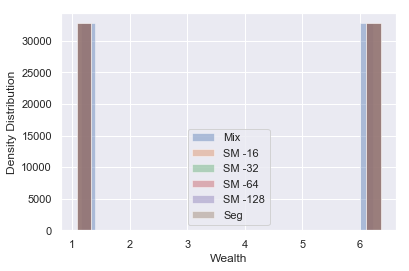

In [0]:
sim_1 = base_model(distr = "Mix")
for _ in range(1000):
    sim_1.update_grid()
    
sim_2 = base_model(distr = "SM", n=16)
for _ in range(1000):
    sim_2.update_grid()

sim_3 = base_model(distr = "SM", n=32)
for _ in range(1000):
    sim_3.update_grid()
    
sim_4 = base_model(distr = "SM", n=64)
for _ in range(1000):
    sim_4.update_grid()
    
sim_5 = base_model(distr = "SM", n=128)
for _ in range(1000):
    sim_5.update_grid()
    
    
sim_6 = base_model(distr = "Seg")
for _ in range(1000):
    sim_6.update_grid()
    
# grid_size= (8, 8), distr = "SM", n=2
    
s= sns.distplot(sim_1.wealth[~np.isnan(sim_1.wealth)], hist=True, kde=False,  label='Mix')
s= sns.distplot(sim_2.wealth[~np.isnan(sim_2.wealth)], hist=True, kde=False, label='SM -16')
s= sns.distplot(sim_3.wealth[~np.isnan(sim_3.wealth)], hist=True, kde=False, label='SM -32')
s= sns.distplot(sim_4.wealth[~np.isnan(sim_4.wealth)], hist=True, kde=False, label='SM -64')
s= sns.distplot(sim_5.wealth[~np.isnan(sim_5.wealth)], hist=True, kde=False, label='SM -128')
s= sns.distplot(sim_6.wealth[~np.isnan(sim_6.wealth)], hist=True, kde=False, label='Seg')


plt.xlabel('Wealth')
plt.ylabel('Density Distribution')
plt.legend()
plt.show()

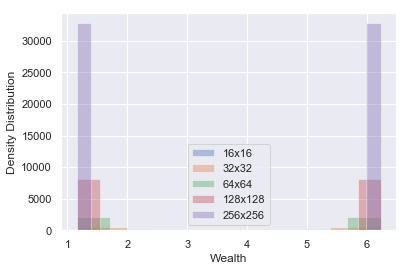

In [0]:
sim_1 = base_model(grid_size = (16, 16), distr = "Mix")
for _ in range(1000):
    sim_1.update_grid()
    
sim_2 = base_model(grid_size = (32, 32), distr = "Mix")
for _ in range(1000):
    sim_2.update_grid()
    
sim_3 = base_model(grid_size = (64, 64), distr = "Mix")
for _ in range(1000):
    sim_3.update_grid()

sim_4 = base_model(grid_size = (128, 128), distr = "Mix")
for _ in range(1000):
    sim_4.update_grid()
    
sim_5 = base_model(grid_size = (256, 256), distr = "Mix")
for _ in range(1000):
    sim_5.update_grid()
    
s= sns.distplot(sim_1.wealth[~np.isnan(sim_1.wealth)], hist=True, kde=False, label='16x16')
s= sns.distplot(sim_2.wealth[~np.isnan(sim_2.wealth)], hist=True, kde=False, label='32x32')
s= sns.distplot(sim_3.wealth[~np.isnan(sim_3.wealth)], hist=True, kde=False, label='64x64')
s= sns.distplot(sim_4.wealth[~np.isnan(sim_4.wealth)], hist=True, kde=False, label='128x128')
s= sns.distplot(sim_5.wealth[~np.isnan(sim_5.wealth)], hist=True, kde=False, label='256x256')


plt.xlabel('Wealth')
plt.ylabel('Density Distribution')
plt.legend()
plt.show()

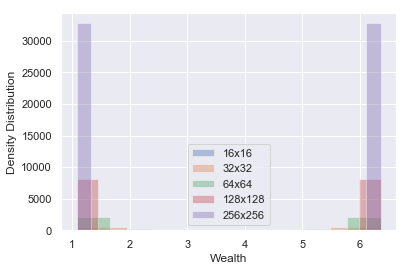

In [0]:
sim_1 = base_model(grid_size = (16, 16), distr = "SM", n=2)
for _ in range(1000):
    sim_1.update_grid()
    
sim_2 = base_model(grid_size = (32, 32), distr = "SM", n=2)
for _ in range(1000):
    sim_2.update_grid()
    
sim_3 = base_model(grid_size = (64, 64), distr = "SM", n=2)
for _ in range(1000):
    sim_3.update_grid()
    
sim_4 = base_model(grid_size = (128, 128), distr = "SM", n=2)
for _ in range(1000):
    sim_4.update_grid()
    
sim_5 = base_model(grid_size = (256, 256), distr = "SM", n=2)
for _ in range(1000):
    sim_5.update_grid()
    
    
s= sns.distplot(sim_1.wealth[~np.isnan(sim_1.wealth)], hist=True, kde=False, label='16x16')
s= sns.distplot(sim_2.wealth[~np.isnan(sim_2.wealth)], hist=True, kde=False, label='32x32')
s= sns.distplot(sim_3.wealth[~np.isnan(sim_3.wealth)], hist=True, kde=False, label='64x64')
s= sns.distplot(sim_4.wealth[~np.isnan(sim_4.wealth)], hist=True, kde=False, label='128x128')
s= sns.distplot(sim_5.wealth[~np.isnan(sim_5.wealth)], hist=True, kde=False, label='256x256')

plt.xlabel('Wealth')
plt.ylabel('Density Distribution')
plt.legend()
plt.show()


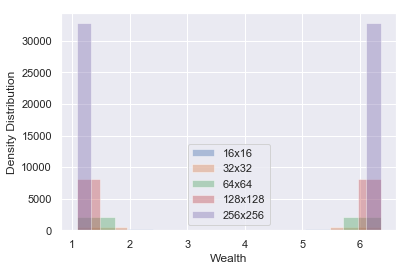

In [0]:
sim_1 = base_model(grid_size = (16, 16), distr = "Seg")
for _ in range(1000):
    sim_1.update_grid()
    
sim_2 = base_model(grid_size = (32, 32), distr = "Seg")
for _ in range(1000):
    sim_2.update_grid()
    
sim_3 = base_model(grid_size = (64, 64), distr = "Seg")
for _ in range(1000):
    sim_3.update_grid()
    
sim_4 = base_model(grid_size = (128, 128), distr = "Seg")
for _ in range(1000):
    sim_4.update_grid()
    
sim_5 = base_model(grid_size = (256, 256), distr = "Seg")
for _ in range(1000):
    sim_5.update_grid()
    
s= sns.distplot(sim_1.wealth[~np.isnan(sim_1.wealth)], hist=True, kde=False, label='16x16')
s= sns.distplot(sim_2.wealth[~np.isnan(sim_2.wealth)], hist=True, kde=False, label='32x32')
s= sns.distplot(sim_3.wealth[~np.isnan(sim_3.wealth)], hist=True, kde=False, label='64x64')
s= sns.distplot(sim_4.wealth[~np.isnan(sim_4.wealth)], hist=True, kde=False, label='128x128')
s= sns.distplot(sim_5.wealth[~np.isnan(sim_5.wealth)], hist=True, kde=False, label='256x256')

plt.xlabel('Wealth')
plt.ylabel('Density Distribution')
plt.legend()
plt.show()

# Correlated 

In [0]:
all_models_avg = [] 
all_models_m = []
all_models_mx = [] 
all_models_mn = []  

for distr in ["Seg", "SM", "Mix"]:
    
    overall_avg_models = []
    overall_median_models = []
    overall_max_models = []
    overall_min_models = []
    
    for i in range(1):
        sim = base_model(distr=distr)
        sims_avg_models=[]
        sims_median_models=[]
        sims_max_models=[]
        sims_min_models=[]
        
        for _ in range(5000):
            sim.update_grid()
            sims_avg_models.append(sim.get_avg_val(sim.wealth))
            sims_median_models.append(sim.get_median(sim.wealth))
            sims_max_models.append(sim.get_max_val(sim.wealth))
            sims_min_models.append(sim.get_min_val(sim.wealth))
            
        overall_avg_models.append(sims_avg_models)
        overall_median_models.append(sims_median_models)
        overall_max_models.append(sims_max_models)
        overall_min_models.append(sims_min_models)
        
    all_models_avg.append(overall_avg_models)
    all_models_m.append(overall_median_models)
    all_models_mx.append(overall_max_models)
    all_models_mn.append(overall_min_models)

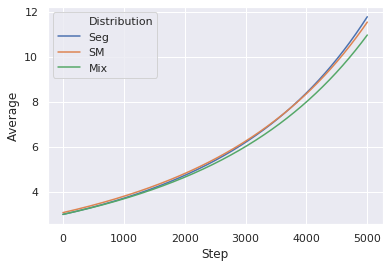

In [0]:
data_avg = []
for i in range(5000):
    for avg in all_models_avg[0]:
        data_avg.append((i, avg[i], "Seg"))
    
    for avg in all_models_avg[1]:
        data_avg.append((i, avg[i], "SM"))
    
    for avg in all_models_avg[2]:
        data_avg.append((i, avg[i], "Mix"))
        
    
da = pd.DataFrame(data_avg, columns = ["Step", "Average", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Average", hue="Distribution", data=da)
L= plt.legend()
# plt.yscale('log')
plt.show()

In [0]:
da

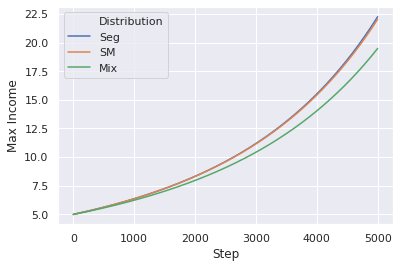

In [0]:
data_mx = []
for i in range(5000):
    for mx in all_models_mx[0]:
        data_mx.append((i, mx[i], "Seg"))
    
    for mx in all_models_mx[1]:
        data_mx.append((i, mx[i], "SM"))
    
    for mx in all_models_mx[2]:
        data_mx.append((i, mx[i], "Mix"))
    

dmx = pd.DataFrame(data_mx, columns = ["Step", "Max Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Max Income", hue="Distribution", data=dmx, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

In [0]:
dmx

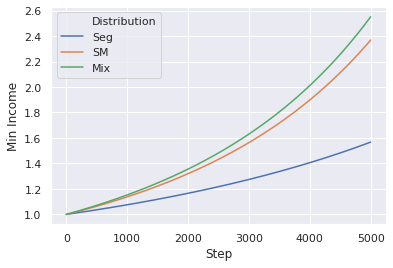

In [0]:
data_mn = []
for i in range(5000):
    for mn in all_models_mn[0]:
        data_mn.append((i, mn[i], "Seg"))
    
    for mn in all_models_mn[1]:
        data_mn.append((i, mn[i], "SM"))
    
    for mn in all_models_mn[2]:
        data_mn.append((i, mn[i], "Mix"))

dmn = pd.DataFrame(data_mn, columns = ["Step", "Min Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Min Income", hue="Distribution", data=dmn, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

In [0]:
dmn

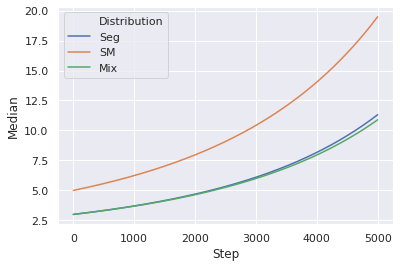

In [0]:
data_m = []
for i in range(5000):
    for m in all_models_m[0]:
        data_m.append((i, m[i], "Seg"))
    
    for m in all_models_m[1]:
        data_m.append((i, m[i], "SM"))
        
    for m in all_models_m[2]:
        data_m.append((i, m[i], "Mix"))

dm = pd.DataFrame(data_m, columns = ["Step", "Median", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Median", hue="Distribution", data=dm, legend='brief')
# L=plt.legend()
# plt.yscale('log')
plt.show()

In [0]:
dm

# Uncorrelated

In [0]:
all_models_avg = [] 
all_models_m = []
all_models_mx = [] 
all_models_mn = []  

for distr in ["Seg", "SM", "Mix"]:
    
    overall_avg_models = []
    overall_median_models = []
    overall_max_models = []
    overall_min_models = []
    
    for i in range(1):
        sim = Stochastic_Schelling(distr=distr)
        sims_avg_models=[]
        sims_median_models=[]
        sims_max_models=[]
        sims_min_models=[]
        
        for _ in range(5000):
            sim.update_grid()
            sims_avg_models.append(sim.get_avg_val(sim.wealth))
            sims_median_models.append(sim.get_median(sim.wealth))
            sims_max_models.append(sim.get_max_val(sim.wealth))
            sims_min_models.append(sim.get_min_val(sim.wealth))
            
        overall_avg_models.append(sims_avg_models)
        overall_median_models.append(sims_median_models)
        overall_max_models.append(sims_max_models)
        overall_min_models.append(sims_min_models)
        
    all_models_avg.append(overall_avg_models)
    all_models_m.append(overall_median_models)
    all_models_mx.append(overall_max_models)
    all_models_mn.append(overall_min_models)

In [0]:
data_avg = []
for i in range(5000):
    for avg in all_models_avg[0]:
        data_avg.append((i, avg[i], "Seg"))
    
    for avg in all_models_avg[1]:
        data_avg.append((i, avg[i], "SM"))
    
    for avg in all_models_avg[2]:
        data_avg.append((i, avg[i], "Mix"))
        
    
da = pd.DataFrame(data_avg, columns = ["Step", "Average", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Average", hue="Distribution", data=da, legend='brief')
# L=plt.legend()
# plt.yscale('log')
# plt.axis([420,500, (5*10**3), np.max(da.Average)])
plt.show()

In [0]:
data_mx = []
for i in range(5000):
    for mx in all_models_mx[0]:
        data_mx.append((i, mx[i], "Seg"))
    
    for mx in all_models_mx[1]:
        data_mx.append((i, mx[i], "SM"))
    
    for mx in all_models_mx[2]:
        data_mx.append((i, mx[i], "Mix"))

dmx = pd.DataFrame(data_mx, columns = ["Step", "Max Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Max Income", hue="Distribution", data=dmx, legend='brief')
# L=plt.legend()
# plt.yscale('log')
plt.show()

In [0]:
data_mn = []
for i in range(5000):
    for mn in all_models_mn[0]:
        data_mn.append((i, mn[i], "Seg"))
    
    for mn in all_models_mn[1]:
        data_mn.append((i, mn[i], "SM"))
        
    for mn in all_models_mn[2]:
        data_mn.append((i, mn[i], "Mix"))

dmn = pd.DataFrame(data_mn, columns = ["Step", "Min Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Min Income", hue="Distribution", data=dmn, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

In [0]:
data_m = []
for i in range(5000):
    for m in all_models_m[0]:
        data_m.append((i, m[i], "Seg"))
    
    for m in all_models_m[1]:
        data_m.append((i, m[i], "SM"))
        
    for m in all_models_m[2]:
        data_m.append((i, m[i], "Mix"))

dm = pd.DataFrame(data_m, columns = ["Step", "Median", "Segregation"])
ax = sns.lineplot(x= "Step", y= "Median", hue="Segregation", data=dm, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

# Scaling - Double Size (20, 20)

In [0]:
all_models_avg = [] 
all_models_m = []
all_models_mx = [] 
all_models_mn = []  

for distr in ["Seg", "SM", "Mix"]:
    
    overall_avg_models = []
    overall_median_models = []
    overall_max_models = []
    overall_min_models = []
    
    for i in range(1):
        sim = base_model(grid_size = (20, 20), distr=distr)
        sims_avg_models=[]
        sims_median_models=[]
        sims_max_models=[]
        sims_min_models=[]
        
        for _ in range(5000):
            sim.update_grid()
            sims_avg_models.append(sim.get_avg_val(sim.wealth))
            sims_median_models.append(sim.get_median(sim.wealth))
            sims_max_models.append(sim.get_max_val(sim.wealth))
            sims_min_models.append(sim.get_min_val(sim.wealth))
            
        overall_avg_models.append(sims_avg_models)
        overall_median_models.append(sims_median_models)
        overall_max_models.append(sims_max_models)
        overall_min_models.append(sims_min_models)
        
    all_models_avg.append(overall_avg_models)
    all_models_m.append(overall_median_models)
    all_models_mx.append(overall_max_models)
    all_models_mn.append(overall_min_models)

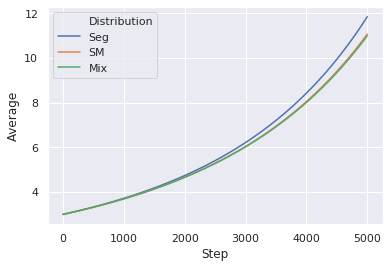

In [0]:
data_avg = []
for i in range(5000):
    for avg in all_models_avg[0]:
        data_avg.append((i, avg[i], "Seg"))
    
    for avg in all_models_avg[1]:
        data_avg.append((i, avg[i], "SM"))
        
    for avg in all_models_avg[2]:
        data_avg.append((i, avg[i], "Mix"))
        
    
da = pd.DataFrame(data_avg, columns = ["Step", "Average", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Average", hue="Distribution", data=da, legend='brief')
L=plt.legend()
# plt.yscale('log')
# plt.axis([420,500, (5*10**3), np.max(da.Average)])
plt.show()

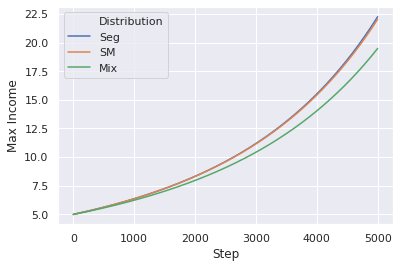

In [0]:
data_mx = []
for i in range(5000):
    for mx in all_models_mx[0]:
        data_mx.append((i, mx[i], "Seg"))
    
    for mx in all_models_mx[1]:
        data_mx.append((i, mx[i], "SM"))
        
    for mx in all_models_mx[2]:
        data_mx.append((i, mx[i], "Mix"))

dmx = pd.DataFrame(data_mx, columns = ["Step", "Max Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Max Income", hue="Distribution", data=dmx, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

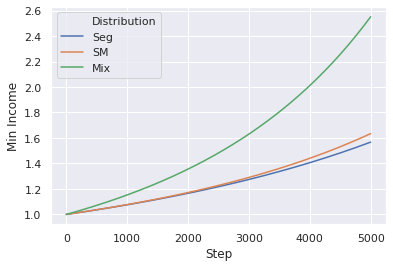

In [0]:
data_mn = []
for i in range(5000):
    for mn in all_models_mn[0]:
        data_mn.append((i, mn[i], "Seg"))
    
    for mn in all_models_mn[1]:
        data_mn.append((i, mn[i], "SM"))
        
    for mn in all_models_mn[2]:
        data_mn.append((i, mn[i], "Mix"))

dmn = pd.DataFrame(data_mn, columns = ["Step", "Min Income", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Min Income", hue="Distribution", data=dmn, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

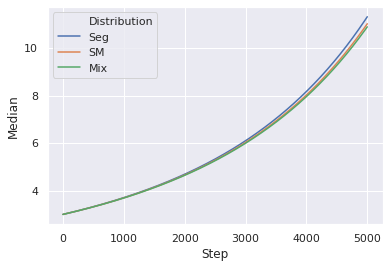

In [0]:
data_m = []
for i in range(5000):
    for m in all_models_m[0]:
        data_m.append((i, m[i], "Seg"))
    
    for m in all_models_m[1]:
        data_m.append((i, m[i], "SM"))
        
    for m in all_models_m[2]:
        data_m.append((i, m[i], "Mix"))

dm = pd.DataFrame(data_m, columns = ["Step", "Median", "Distribution"])
ax = sns.lineplot(x= "Step", y= "Median", hue="Distribution", data=dm, legend='brief')
L=plt.legend()
# plt.yscale('log')
plt.show()

# Check Effect of Neighborhood Size

In [0]:
all_models_avg = [] 
all_models_m = []
all_models_mx = [] 
all_models_mn = []  

for n in [2, 4, 8]:
    
    overall_avg_models = []
    overall_median_models = []
    overall_max_models = []
    overall_min_models = []
    
    for i in range(1):
        sim = Stochastic_Schelling(n= n)
        sims_avg_models=[]
        sims_median_models=[]
        sims_max_models=[]
        sims_min_models=[]
        
        for _ in range(5000):
            sim.update_grid()
            sims_avg_models.append(sim.get_avg_val(sim.wealth))
            sims_median_models.append(sim.get_median(sim.wealth))
            sims_max_models.append(sim.get_max_val(sim.wealth))
            sims_min_models.append(sim.get_min_val(sim.wealth))
            
        overall_avg_models.append(sims_avg_models)
        overall_median_models.append(sims_median_models)
        overall_max_models.append(sims_max_models)
        overall_min_models.append(sims_min_models)
        
    all_models_avg.append(overall_avg_models)
    all_models_m.append(overall_median_models)
    all_models_mx.append(overall_max_models)
    all_models_mn.append(overall_min_models)

In [0]:
data_avg = []
for i in range(5000):
    for avg in all_models_avg[0]:
        data_avg.append((i, avg[i], 2))
    
    for avg in all_models_avg[1]:
        data_avg.append((i, avg[i], 4))
        
    for avg in all_models_avg[2]:
        data_avg.append((i, avg[i], 8))
        
    
da = pd.DataFrame(data_avg, columns = ["Step", "Average", "Neighborhood Size"])
da["Neighborhood Size"] = ["$%s$" % x for x in da["Neighborhood Size"]]

ax = sns.lineplot(x= "Step", y= "Average", hue="Neighborhood Size", data=da, legend='brief')
L=plt.legend()
plt.show()

In [0]:
da

In [0]:
data_mx = []
for i in range(5000):
    for mx in all_models_mx[0]:
        data_mx.append((i, mx[i], 2))
    
    for mx in all_models_mx[1]:
        data_mx.append((i, mx[i], 4))
        
    for mx in all_models_mx[2]:
        data_mx.append((i, mx[i], 8))

dmx = pd.DataFrame(data_mx, columns = ["Step", "Max Income", "Neighborhood Size"])

dmx["Neighborhood Size"] = ["$%s$" % x for x in dmx["Neighborhood Size"]]

ax = sns.lineplot(x= "Step", y= "Max Income", hue="Neighborhood Size", data=dmx, legend='brief')
L=plt.legend()
plt.show()

In [0]:
dmx

In [0]:
data_mn = []
for i in range(5000):
    for mn in all_models_mn[0]:
        data_mn.append((i, mn[i], 2))
    
    for mn in all_models_mn[1]:
        data_mn.append((i, mn[i], 4))
        
    for mn in all_models_mn[2]:
        data_mn.append((i, mn[i], 8))

dmn = pd.DataFrame(data_mn, columns = ["Step", "Min Income", "Neighborhood Size"])

dmn["Neighborhood Size"] = ["$%s$" % x for x in dmn["Neighborhood Size"]]

ax = sns.lineplot(x= "Step", y= "Min Income", hue="Neighborhood Size", data=dmn, legend='brief')
L=plt.legend()
plt.show()

In [0]:
dmn

In [0]:
data_m = []
for i in range(5000):
    for m in all_models_m[0]:
        data_m.append((i, m[i], 2))
    
    for m in all_models_m[1]:
        data_m.append((i, m[i], 4))
        
    for m in all_models_m[2]:
        data_m.append((i, m[i], 8))

dm = pd.DataFrame(data_m, columns = ["Step", "Median", "Neighborhood Size"])

dm["Neighborhood Size"] = ["$%s$" % x for x in dm["Neighborhood Size"]]

ax = sns.lineplot(x= "Step", y= "Median", hue="Neighborhood Size", data=dm, legend='brief')
L=plt.legend()
plt.show()

In [0]:
dm

## 4x4

In [0]:
all_models_avg = [] 
all_models_m = []
all_models_mx = [] 
all_models_mn = []  

for n in [1, 2]:
    
    overall_avg_models = []
    overall_median_models = []
    overall_max_models = []
    overall_min_models = []
    
    for i in range(1):
        sim = Stochastic_Schelling(n= n)
        sims_avg_models=[]
        sims_median_models=[]
        sims_max_models=[]
        sims_min_models=[]
        
        for _ in range(5000):
            sim.update_grid()
            sims_avg_models.append(sim.get_avg_val(sim.wealth))
            sims_median_models.append(sim.get_median(sim.wealth))
            sims_max_models.append(sim.get_max_val(sim.wealth))
            sims_min_models.append(sim.get_min_val(sim.wealth))
            
        overall_avg_models.append(sims_avg_models)
        overall_median_models.append(sims_median_models)
        overall_max_models.append(sims_max_models)
        overall_min_models.append(sims_min_models)
        
    all_models_avg.append(overall_avg_models)
    all_models_m.append(overall_median_models)
    all_models_mx.append(overall_max_models)
    all_models_mn.append(overall_min_models)

In [0]:
data_avg = []
for i in range(5000):
    for avg in all_models_avg[0]:
        data_avg.append((i, avg[i], 1))
    
    for avg in all_models_avg[1]:
        data_avg.append((i, avg[i], 2))
    
da = pd.DataFrame(data_avg, columns = ["Step", "Average", "Neighborhood Size"])
da["Neighborhood Size"] = ["$%s$" % x for x in da["Neighborhood Size"]]

ax = sns.lineplot(x= "Step", y= "Average", hue="Neighborhood Size", data=da, legend='brief')
L=plt.legend()
plt.show()

In [0]:
da

In [0]:
data_mx = []
for i in range(5000):
    for mx in all_models_mx[0]:
        data_mx.append((i, mx[i], 1))
    
    for mx in all_models_mx[1]:
        data_mx.append((i, mx[i], 2))

dmx = pd.DataFrame(data_mx, columns = ["Step", "Max Income", "Neighborhood Size"])

dmx["Neighborhood Size"] = ["$%s$" % x for x in dmx["Neighborhood Size"]]

ax = sns.lineplot(x= "Step", y= "Max Income", hue="Neighborhood Size", data=dmx, legend='brief')
L=plt.legend()
plt.show()

In [0]:
grid_size=(5, 5)
growth_rate = np.ones(grid_size)
wealth = np.ones(grid_size)*5

wealth[:, :int(grid_size[1]/2)]= 1

C=10**-5
growth_rate = C*wealth 

In [0]:
growth_rate